In [1]:
# Basic libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import warnings

import seaborn as sns
import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport

In [2]:
# Options
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### Load FEMA Data

In [3]:
# Load FEMA data
flData = pd.read_csv("../data/open-fema/FEMA-Large-DR-4337-FL.csv")
txData = pd.read_csv("../data/open-fema/FEMA-Large-DR-4332-TX.csv")
prData = pd.read_csv("../data/open-fema/FEMA-Large-DR-4339-PR.csv")

In [4]:
# Combine FL + PR + TX datasets
femaDf = pd.concat([flData, txData, prData])
print(f"There are {len(femaDf)} records in the dataframe.")

There are 4661523 records in the dataframe.


In [5]:
# Look at data types for each of the columns
femaDf.dtypes

disasterNumber                       int64
damagedCity                         object
damagedStateAbbreviation            object
damagedZipCode                     float64
householdComposition                 int64
grossIncome                        float64
specialNeeds                          bool
ownRent                             object
residenceType                       object
homeOwnersInsurance                   bool
floodInsurance                        bool
inspected                             bool
rpfvl                              float64
habitabilityRepairsRequired         object
destroyed                             bool
waterLevel                         float64
floodDamage                           bool
foundationDamage                      bool
foundationDamageAmount             float64
roofDamage                            bool
roofDamageAmount                   float64
tsaEligible                           bool
tsaCheckedIn                          bool
rentalAssis

In [6]:
femaDf.drop_duplicates(inplace=True)
print(f"There are {len(femaDf)} records after dropping any duplicates.")

There are 4661523 records after dropping any duplicates.


In [7]:
# Change incorrect datatype
femaDf['habitabilityRepairsRequired'] = femaDf['habitabilityRepairsRequired'].astype('bool')
femaDf['primaryResidence'] = femaDf['primaryResidence'].astype('bool')
femaDf['censusBlockId'] = femaDf['censusBlockId'].astype('str')
print(f"habitabilityRepairsRequired datatype: {femaDf['habitabilityRepairsRequired'].dtype}")
print(f"primaryResidence datatype: {femaDf['primaryResidence'].dtype}")
print(f"censusBlockId datatype: {femaDf['censusBlockId'].dtype}")

habitabilityRepairsRequired datatype: bool
primaryResidence datatype: bool
censusBlockId datatype: object


In [8]:
# Create census tract IDs for FEMA dataset
femaDf['censusTractId'] = femaDf.apply(lambda row: row.censusBlockId[0:11], axis=1)
femaDf[['censusBlockId', 'censusTractId']].head()

,censusBlockId,censusTractId
0,120111105011006.0,12011110501
1,120860011032003.0,12086001103
2,120830012043000.0,12083001204
3,120860135002000.0,12086013500
4,120090641241018.0,12009064124


### Load Census Demographics

In [9]:
# Load demographics data
demoDf = pd.read_csv("../data/census-tract/census-tract-demographics-trim.csv")
demoDf.head(3)

,censusid,gisjoin,tractid,tractname,county,state,total_population,male_population,female_population,total_population_edu,high_school_grad,bachelors_degree,graduate_prof_degree,high_school_grad_rate,bachelors_degree_rate,graduate_prof_degree_rate,bachelors_plus_degree_rate,total_population_employ,labor_force_total,civilian_labor_force,employed_labor_force,unemployed_labor_force,armed_forces_labor_force,not_labor_force_total,labor_force_rate,civilian_labor_rate,employed_labor_rate,unemployed_labor_rate,armed_forces_labor_rate,not_labor_force_rate,total_population_income,income_less_10k,income_10k_15k,income_15k_20k,income_20k_25k,income_25k_30k,income_30k_35k,income_35k_40k,income_40k_45k,income_45k_50k,income_50k_60k,income_60k_75k,income_75k_100k,income_100k_125k,income_125k_150k,income_150k_200k,income_200k_more,median_earnings_total,median_earnings_male,median_earnings_male_fulltime,median_earnings_male_other,median_earnings_female,median_earnings_female_fulltime,median_earnings_female_other,total_households_poverty,below_poverty,below_poverty_family,below_poverty_family_married,below_poverty_family_other,below_poverty_family_other_male_no_spouse,below_poverty_family_other_female_no_spouse,below_poverty_nonfamily,below_poverty_nonfamily_male,below_poverty_nonfamily_female,above_poverty,above_poverty_family,above_poverty_family_married,above_poverty_family_other,above_poverty_family_other_male_no_spouse,above_poverty_family_other_female_no_spouse,above_poverty_nonfamily,above_poverty_nonfamily_male,above_poverty_nonfamily_female,below_poverty_rate,below_poverty_family_rate,below_poverty_family_married_rate,below_poverty_family_other_rate,below_poverty_family_other_male_no_spouse_rate,below_poverty_family_other_female_no_spouse_rate,below_poverty_nonfamily_rate,below_poverty_nonfamily_male_rate,below_poverty_nonfamily_female_rate,above_poverty_rate,above_poverty_family_rate,above_poverty_family_married_rate,above_poverty_family_other_rate,above_poverty_family_other_male_no_spouse_rate,above_poverty_family_other_female_no_spouse_rate,above_poverty_nonfamily_rate,above_poverty_nonfamily_male_rate,above_poverty_nonfamily_female_rate,total_population_assist,with_assistance,without_assistance,with_assistance_rate,without_assistance_rate,total_housing_units,total_housing_units_rate,occupied_housing_units,occupied_housing_units_rate,vacant_housing_units,vacant_housing_units_rate,homeowner_vacancy_rate,homeowner_vacancy_rate_rate,rental_vacancy_rate,rental_vacancy_rate_rate,built_total_housing_units,built_total_housing_units_rate,built_2014_or_later,built_2014_or_later_rate,built_2010_to_2013,built_2010_to_2013_rate,built_2000_to_2009,built_2000_to_2009_rate,built_1990_to_1999,built_1990_to_1999_rate,built_1980_to_1989,built_1980_to_1989_rate,built_1970_to_1979,built_1970_to_1979_rate,built_1960_to_1969,built_1960_to_1969_rate,built_1950_to_1959,built_1950_to_1959_rate,built_1940_to_1949,built_1940_to_1949_rate,built_1939_or_earlier,built_1939_or_earlier_rate,tenure_occupied_housing_units,tenure_occupied_housing_units_rate,owner_occupied,owner_occupied_rate,renter_occupied,renter_occupied_rate,avg_size_owner_unit,avg_size_owner_unit_rate,avg_size_renter_unit,avg_size_of_renter__unit_rate,moved_occupied_housing_unit,moved_occupied_housing_unit_rate,moved_in_2015_or_later,moved_in_2015_or_later_rate,moved_in_2010_to_2014,moved_in_2010_to_2014_rate,moved_in_2000_to_2009,moved_in_2000_to_2009_rate,moved_in_1990_to_1999,moved_in_1990_to_1999_rate,moved_in_1980_to_1989,moved_in_1980_to_1989_rate,moved_in_1979_and_earlier,moved_in_1979_and_earlier_rate,lacking_complete_plumbing_facilities,lacking_complete_plumbing_facilities_rate,lacking_complete_kitchen_facilities,lacking_complete_kitchen_facilities_rate,no_telephone_service_available,no_telephone_service_available_rate,value_less_50k,value_less_50k_rate,value_50k_100k,value_50k_100k_rate,value_100k_150k,value_100k_150k_rate,value_150k_200k,value_150k_200k_rate,value_200k_300k,value_200k_30

In [10]:
# Check vars in index
print(demoDf.columns)

Index(['censusid', 'gisjoin', 'tractid', 'tractname', 'county', 'state',
       'total_population', 'male_population', 'female_population',
       'total_population_edu',
       ...
       'total_foreign_rate', 'foreign_citizen_rate',
       'foreign_non_citizen_rate', 'poverty_rank', 'unemployed_rank',
       'earnings_rank', 'owner_rank', 'house_old_rank', 'dvi_raw', 'dvi'],
      dtype='object', length=328)


In [11]:
# Change to tractid datatype to string
demoDf['tractid'] = demoDf['tractid'].astype('str')
print(f"tractid datatype: {demoDf['tractid'].dtype}")

tractid datatype: object


In [12]:
# Select subset of variables
demoDf = demoDf[['censusid', 'tractid', 'tractname', 'county', 'state', 'below_poverty_rate', 'median_earnings_total',
                 'unemployed_labor_rate', 'built_1979_or_earlier_rate', 'owner_occupied_rate', 'dvi']]

demoDf.head(3)

,censusid,tractid,tractname,county,state,below_poverty_rate,median_earnings_total,unemployed_labor_rate,built_1979_or_earlier_rate,owner_occupied_rate,dvi
0,1400000US12001000200,12001000200,"Census Tract 2, Alachua County, Florida",Alachua County,Florida,0.561760,6752,0.033528,0.412270,0.176396,0.632103
1,1400000US12001000301,12001000301,"Census Tract 3.01, Alachua County, Florida",Alachua County,Florida,0.347230,20481,0.067448,0.630089,0.205597,0.719638
2,1400000US12001000302,12001000302,"Census Tract 3.02, Alachua County, Florida",Alachua County,Florida,0.244323,25108,0.086468,0.834117,0.425976,0.740157


### Combine Demographics with FEMA data

In [13]:
# Merge demographics and FEMA datasets
df = pd.merge(femaDf, demoDf, left_on='censusTractId', right_on='tractid')

In [14]:
# Check how many rows we have in the merged dataframe
print(f"There are {len(df)} records in the merged dataset.")
print(f"This is a {len(femaDf) - len(df)} difference b/w the original dataset and the merged.")

There are 4599003 records in the merged dataset.
This is a 62520 difference b/w the original dataset and the merged.


In [15]:
# Check how many census tracts are represented between TX & FL
print(f"There are {len(df['tractid'].unique())} tracts represented in the dataset.")
print(f"Of these, {len(df.loc[df['damagedStateAbbreviation'] == 'PR', 'censusid'].unique())} are from PR.")
print(f"Of these, {len(df.loc[df['damagedStateAbbreviation'] == 'TX', 'censusid'].unique())} are from TX.")
print(f"Of these, {len(df.loc[df['damagedStateAbbreviation'] == 'FL', 'censusid'].unique())} are from FL.")

There are 7461 tracts represented in the dataset.
Of these, 884 are from PR.
Of these, 2453 are from TX.
Of these, 4127 are from FL.


### Feature Engineering

In [16]:
# Define all dollar amount columns
amountCols = ['foundationDamageAmount', 'roofDamageAmount', 'rentalAssistanceAmount', 
              'replacementAmount','repairAmount', 'rpfvl', 'ppfvl']

# Set them to zero if null
df[amountCols] = df[amountCols].fillna(0)

# Calculate the aggregated haAmount
df['haAmount'] = df['rentalAssistanceAmount'] + df['replacementAmount'] + df['repairAmount']

print('Total ${:,.2f} in HA payouts'.format(df['haAmount'].sum()))
print('Total ${:,.2f} in mainland HA payouts'.format(df.loc[df['damagedStateAbbreviation'] != 'PR', 'haAmount'].sum()))

Total $2,578,826,315.71 in HA payouts
Total $1,930,647,257.50 in mainland HA payouts


In [17]:
# Drop the individual amount columns
df.drop(['rentalAssistanceAmount', 'replacementAmount','repairAmount'], axis=1, inplace=True)

In [18]:
# Convert boolean columns to int
bool_cols = ['specialNeeds', 'homeOwnersInsurance', 'floodInsurance', 'inspected', 'destroyed', 
             'habitabilityRepairsRequired', 'floodDamage', 'foundationDamage', 'roofDamage', 
             'tsaEligible', 'rentalAssistanceEligible', 'repairAssistanceEligible', 
             'replacementAssistanceEligible', 'sbaEligible', 'primaryResidence']

df[bool_cols] = df[bool_cols].astype(int)

In [19]:
# Fill the na's with zero's in waterLevel 
df['waterLevel'].fillna(0, inplace=True)

In [20]:
# One-hot encode the categorical variables
cat_cols = ['ownRent', 'residenceType']
for col in cat_cols:
    df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
df.drop(cat_cols, axis=1, inplace=True)

### Read FEMA Large Demographics and concatenate them

In [21]:
train = pd.read_csv("../data/open-fema/FEMA-Large-Demographics-FL-TX.csv")

In [22]:
test = pd.read_csv("../data/open-fema/FEMA-Large-Demographics-PR.csv")

In [23]:
# Combine FL + PR + TX datasets
df = pd.concat([train, test])
print(f"There are {len(df)} records in the dataframe.")

There are 4599003 records in the dataframe.


### Outlier Detection

In [24]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
disasterNumber,4599003.0,4.336491e+03,2.351628e+00,4.332000e+03,4.337000e+03,4.337000e+03,4.337000e+03,4.339000e+03
damagedZipCode,4599003.0,3.438386e+04,2.496073e+04,0.000000e+00,3.213700e+04,3.316800e+04,3.427000e+04,9.976600e+04
householdComposition,4599003.0,2.207699e+00,1.444158e+00,1.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,9.900000e+01
grossIncome,3742775.0,5.967531e+04,5.316178e+05,0.000000e+00,1.200000e+04,2.472000e+04,4.500000e+04,1.000000e+08
specialNeeds,4599003.0,2.381168e-02,1.524621e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
homeOwnersInsurance,4599003.0,2.737626e-01,4.458886e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
floodInsurance,4599003.0,7.845679e-02,2.688891e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
inspected,4599003.0,4.992234e-01,4.999995e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
rpfvl,1494840.0,2.172704e+03,8.887977e+03,0.000000e+00,0.000000e+00,0.000000e+00,6.097225e+02,3.423008e+05
habitabilityRepairsRequired,4599003.0,7.487321e-01,4.337423e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [25]:
df['householdComposition'].describe().transpose()

count    4.599003e+06
mean     2.207699e+00
std      1.444158e+00
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      3.000000e+00
max      9.900000e+01
Name: householdComposition, dtype: float64

In [26]:
df['householdComposition'] = df['householdComposition'].astype(int)
print(f"householdComposition datatype: {df['householdComposition'].dtype}")

householdComposition datatype: int32


In [27]:
profile = ProfileReport(df, minimal=True)
profile.to_file("output.html")

Summarize dataset:   0%|          | 0/78 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [28]:
profile

#### Housing Assistance Amount - Oulier Detection

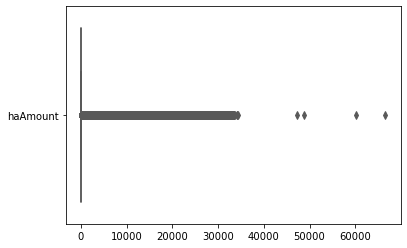

In [29]:
df_1 = df[['haAmount']]
ax = sns.boxplot(data=df_1, orient="h", palette="Set2")

array([[<AxesSubplot:title={'center':'haAmount'}>]], dtype=object)

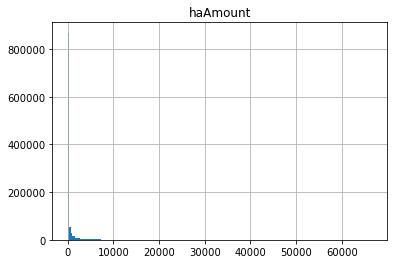

In [30]:
df_1.hist(column='haAmount', bins=200)

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

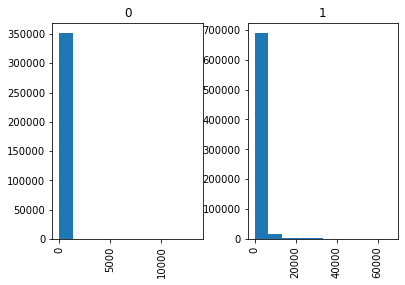

In [31]:
df.hist(column='haAmount', by='inspected')

In [32]:
len(df[(df['haAmount']>0) & (df['inspected']==False)])

25223

In [33]:
len(df)

4599003

In [34]:
# Drop noninspected and haAmount > 0
noninspected_haAmount = df[ (df['haAmount'] > 0) & (df['inspected'] == False) ].index
df.drop(noninspected_haAmount , inplace=True)

In [35]:
len(df)

4548557

In [36]:
len(df[(df['haAmount']>33300)])

8

In [37]:
# Drop haAmount > $33,300
maxlimit_haAmount = df[ (df['haAmount'] > 33300) ].index
df.drop(maxlimit_haAmount , inplace=True)

In [38]:
len(df)

4548541

#### Household Composition - Oulier Detection

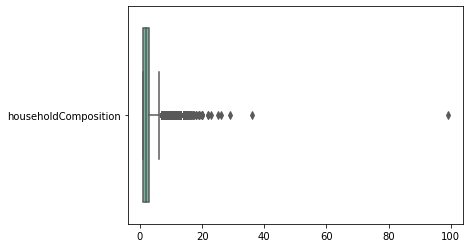

In [39]:
df_2 = df[['householdComposition']]
ax = sns.boxplot(data=df_2, orient="h", palette="Set2")

array([[<AxesSubplot:title={'center':'householdComposition'}>]],
      dtype=object)

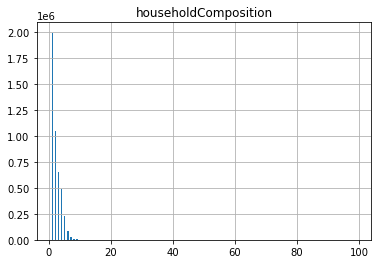

In [40]:
df_2.hist(column='householdComposition', bins=200)

In [41]:
len(df[(df['householdComposition']>15)])

64

In [42]:
max_thresold = df['householdComposition'].quantile(0.99)
max_thresold

7.0

In [43]:
# Drop household family members > 15
maxlimit_household = df[ (df['householdComposition'] > 15) ].index
df.drop(maxlimit_household , inplace=True)

In [44]:
len(df)

4548459

#### Real Property Verified FEMA Loss (rpvfl) - Oulier Detection

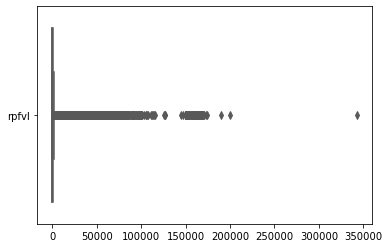

In [45]:
df_3 = df[['rpfvl']]
ax = sns.boxplot(data=df_3, orient="h", palette="Set2")

array([[<AxesSubplot:title={'center':'rpfvl'}>]], dtype=object)

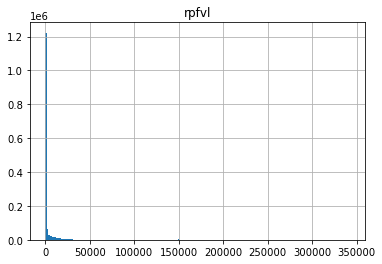

In [46]:
df_3.hist(column='rpfvl', bins=200)

In [47]:
len(df[(df['rpfvl']>250000)])

1

#### waterLevel - Oulier Detection

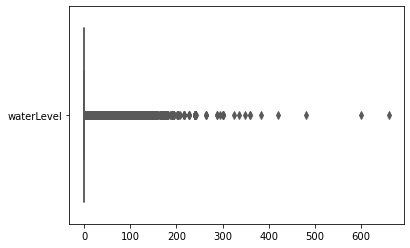

In [48]:
df_4 = df[['waterLevel']]
ax = sns.boxplot(data=df_4, orient="h", palette="Set2")

In [49]:
len(df[(df['waterLevel']>120)])

405

In [50]:
max_thresold = df['waterLevel'].quantile(0.99)
max_thresold

39.0

In [51]:
# Drop water level > 120 inches
maxlimit_waterlevel = df[ (df['waterLevel'] > 120) ].index
df.drop(maxlimit_waterlevel , inplace=True)

In [52]:
len(df)

4548006

### Create Train and Test Clean Version

In [53]:
# Create train (FL/TX) data
trainDf = df.loc[df['damagedStateAbbreviation'] != 'PR', ]

# Write train to csv
trainDf.to_csv("../data/open-fema/FEMA-Large-Demographics-FL-TX_clean.csv", index=False, encoding='utf-8')
print('Train (FL/TX) rows:', len(trainDf))

Train (FL/TX) rows: 3507963


In [54]:
# Create test (PR) data
testDf = df.loc[df['damagedStateAbbreviation'] == 'PR', ]

# Write test to csv
testDf.to_csv("../data/open-fema/FEMA-Large-Demographics-PR_clean.csv", index=False, encoding='utf-8')
print('Test (PR) rows:', len(testDf))

Test (PR) rows: 1040043
